## Introduction

In this notebook, we attempt to predict whether trading the stock index mentioned in a tweet will yield a return greater than 1%, given the popularity, sentiment scores and other features related to the tweet. We assume that we enter into a long position in the stock index at a fixed time, $t_1$, after the tweet, and we similarly sell off the index at a later fixed time, $t_2$. These $t_1$ and $t_2$ are generally treated as hyperparameters and <b> not as features. </b>

We will use 2 Bayesian-based classifiers in this notebook: Naive Bayes Classifier and quadratic discriminant analysis (QDA).




## Naive Bayes Classifier

Recall that the Naive Bayes Model assumes that the likelihood distribution, $P(X_j|y=c)$, for each class $c$ and feature $j$ is independent. To adhere to this central assumption for the model, we will only include features that are not strongly correlated to one another. 

We begin by downloading the data and performing the train-test split. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet("/Users/josht/Documents/tweet_stock_merged_data1.parquet")

In [3]:
df.sample(5)

,time_stamp,entities_cashtags,entities_hashtags,entities_urls,like_count,quote_count,reply_count,retweet_count,text,entities_mentions,...,Company_ticker,time_of_day,morning,evening,night,buy_price,delta_buy,sell_price,delta_sell,return
68817,2020-06-01 20:19:40,0,2,1,313,27,46,103,Stunning scenes coming out of #Michigan. \n\nL...,1,...,ALL,night,0,0,1,96.454914,47480.0,103.063143,303380.0,6.851107
5927,2021-09-22 08:17:13,0,0,1,13,1,3,0,Entain shares surge for second day on increase...,0,...,MGM,morning,0,1,0,40.999900,767.0,44.610000,427427.0,8.805143
61878,2020-11-23 09:13:43,0,0,2,48,3,3,6,Here’s why oysters and champagne go so well to...,0,...,SO,morning,0,1,0,60.950000,1037.0,60.940000,345317.0,-0.016407
43553,2021-04-08 19:26:36,0,0,1,67,0,34,5,that's all we want. We don't want to be whipsa...,0,...,TWTR,night,0,0,1,71.400000,24.0,70.680000,300444.0,-1.008403
33583,2020-12-10 09:36:26,0,0,1,0,0,1,0,Anthropocene: human-made materials now weigh a...,1,...,NOW,morning,0,1,0,523.490000,34.0,544.800000,336754.0,4.070756


In [4]:
df.columns

Index(['time_stamp', 'entities_cashtags', 'entities_hashtags', 'entities_urls',
       'like_count', 'quote_count', 'reply_count', 'retweet_count', 'text',
       'entities_mentions', 'created_at_user', 'followers_count',
       'following_count', 'listed_count', 'tweet_count', 'media_type',
       'Company_name', 'Word_count_News_agencies', 'Word_count_Henry08_pos',
       'Word_count_Henry08_neg', 'Word_count_LM11_pos', 'Word_count_LM11_neg',
       'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg',
       'Tweet_Length_characters', 'Tweet_Length_words', 'Compound_vader',
       'Positive_vader', 'Negative_vader', 'Neutral_vader', 'Company_ticker',
       'time_of_day', 'morning', 'evening', 'night', 'buy_price', 'delta_buy',
       'sell_price', 'delta_sell', 'return'],
      dtype='object')

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2, shuffle = True)

In [6]:
df.shape

(724283, 40)

In [7]:
df_train.shape

(579426, 40)

In [8]:
df_test.shape

(144857, 40)

These are the potential features we will use in our model. The last three are categorical and result from onehot encoding. We will drop the last one to avoid redundancy. 

In [9]:
potential_features = ['like_count', 'quote_count', 'reply_count', 'retweet_count', 'followers_count', 
                      'following_count', 'listed_count', 'tweet_count', 'Word_count_News_agencies', 
                      'Word_count_Henry08_pos', 'Word_count_Henry08_neg', 'Word_count_LM11_pos', 
                      'Word_count_LM11_neg', 'Word_count_Hagenau13_pos', 'Word_count_Hagenau13_neg', 
                      'Tweet_Length_characters', 'Tweet_Length_words', 'Compound_vader', 'Positive_vader', 
                      'Negative_vader', 'Neutral_vader', 'morning', 'evening', 'night']

Now, we employ PCA to select uncorrelated quantitative features.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()

In [11]:
X_quant_train = np.array(df_train[potential_features[:-3]])

In [12]:
X_qt_st = scaler.fit_transform(X_quant_train)
phi_train = pca.fit_transform(X_qt_st)

In [13]:
phi_train.shape

(579426, 21)

In [14]:
print(100 * pca.explained_variance_ratio_)

[1.40934597e+01 1.31595041e+01 1.16750016e+01 1.06370398e+01
 8.93990305e+00 5.52588268e+00 5.06843370e+00 4.43066477e+00
 4.17350833e+00 3.90597530e+00 3.71161270e+00 3.30746823e+00
 2.66763374e+00 2.58382986e+00 2.40633881e+00 2.33297274e+00
 4.52914769e-01 4.45340397e-01 2.70156309e-01 2.12351111e-01
 8.19350610e-06]


Let us get rid of the last five features, as they contribute little to the total variance. Since we centered and scaled the data before applying PCA, the resulting principal components are uncorrelated to one another.

In [15]:
X_train = np.concatenate((phi_train[:, :-5], np.array(df_train[['morning', 'evening']])), axis=1)

In [16]:
np.shape(X_train)

(579426, 18)

In [17]:
phi_test = pca.fit_transform(scaler.fit_transform(np.array(df_test[potential_features[:-3]])))
X_test = np.concatenate((phi_test[:, :-5], np.array(df_test[['morning', 'evening']])), axis=1)

In [18]:
np.shape(X_test)

(144857, 18)

In [19]:
y_train = np.array(df_train["return"] >= 1.0)
y_test = np.array(df_test["return"] >= 1.0)

Now, we are ready to train our Naive Bayes Classifier on the training set.

In [20]:
from sklearn.naive_bayes import GaussianNB

In [21]:
NB = GaussianNB()

NB.fit(X_train, y_train)

GaussianNB()

In [22]:
pred_train = NB.predict(X_train)

In [23]:
acc_train = sum(pred_train == y_train)/y_train.shape[0]
print("Training accuracy:", acc_train)

Training accuracy: 0.6227128226900416


In [24]:
pred_test = NB.predict(X_test)
acc_test = sum(pred_test == y_test)/y_test.shape[0]
print("Test accuracy:", acc_test)

Test accuracy: 0.6175331533857529


In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Training precision score:", precision_score(y_train, pred_train))
print("Training recall score:", recall_score(y_train, pred_train))
print("Training F1 score:", f1_score(y_train, pred_train))

print("Test precision score:", precision_score(y_test, pred_test))
print("Test recall score:", recall_score(y_test, pred_test))
print("Test F1 score:", f1_score(y_test, pred_test))

Training precision score: 0.37897942234935866
Training recall score: 0.038497590971297874
Training F1 score: 0.06989508079544583
Test precision score: 0.3738232614637109
Test recall score: 0.045812322063229195
Test F1 score: 0.08162182770567077


In [26]:
from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, pred_train)
print("Training ROC AUC:", auc_train)

auc_test = roc_auc_score(y_test, pred_test)
print("Test ROC AUC:", auc_test)

Training ROC AUC: 0.5008639317194017
Test ROC AUC: 0.5002756680336778


In [68]:
print(np.sum(y_train)/np.shape(y_train)[0])
print(np.sum(pred_train)/np.shape(pred_train)[0])

0.36823338959591045
0.03740598454332391


In [69]:
print(np.sum(y_test)/np.shape(y_test)[0])
print(np.sum(pred_test)/np.shape(pred_test)[0])

0.3709934625182076
0.04546552807251289


The AUC is basically that of a random model. Also, the model rarely predicts a stock to have return of at least 1%.

## Quadratic Discriminant Analysis

QDA assumes that the joint likelihood distribution for each class $c$ is a multivariate normal distribution: $P(X_1,\ldots,X_m|y=c) \sim \mathcal{N}(\mu_c, \Sigma_c)$. In order to closely approximate the model assumption, we will take the logarithm of some of the features whose distributions are highly skewed to the right.

Then, the natural starting point is to look at the histogram of all quantitative features.

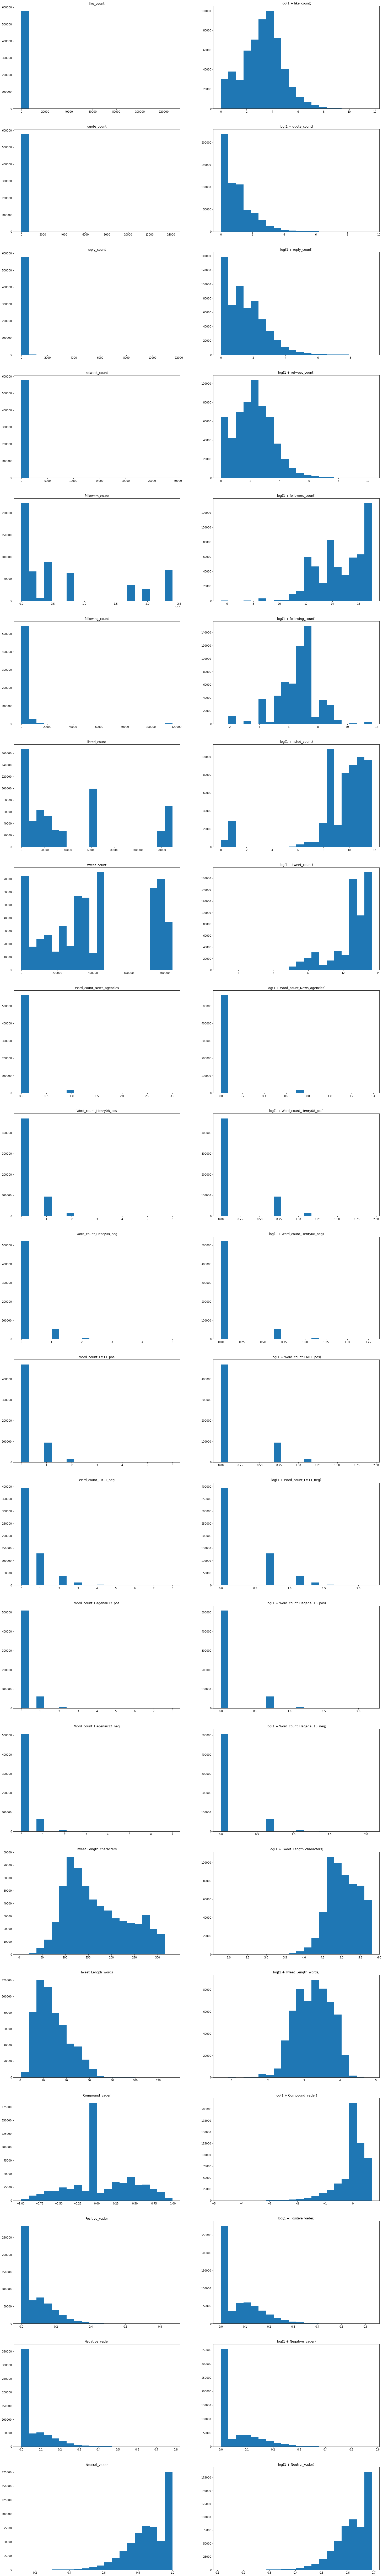

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(potential_features)-3, 2, figsize=(25,180))

for i in range(len(potential_features)-3):
    ax[i, 0].hist(df_train[potential_features[i]], bins=20)
    ax[i, 0].set_title(potential_features[i])
    ax[i, 1].hist(np.log(1 + df_train[potential_features[i]]), bins=20)
    ax[i, 1].set_title("log(1 + "+potential_features[i]+")")

It is unfortunately the case for a lot of features that neither its logarithm nor the feature itself is normally distributed. However, we will do the best we can. The features whose distribution become closer to normal distribution once one takes the logarithm are listed below. 

In [28]:
features_log = ['like_count', 'quote_count', 'reply_count', 'retweet_count', 'following_count', 
                'Tweet_Length_characters', 'Tweet_Length_words']
features_non_log = [x for x in potential_features[:-1] if x not in features_log]

In [29]:
X_train2 = np.concatenate((np.array(np.log(1 + df_train[features_log])), 
                          np.array(df_train[features_non_log])), axis=1)
X_test2 = np.concatenate((np.array(np.log(1 + df_test[features_log])), 
                          np.array(df_test[features_non_log])), axis=1)

In [30]:
y_train2 = np.array(df_train["return"] >= 1.0)
y_test2 = np.array(df_test["return"] >= 1.0)

In [31]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

QDA = QuadraticDiscriminantAnalysis()

In [32]:
QDA.fit(X_train2, y_train2)

QuadraticDiscriminantAnalysis()

In [33]:
pred_train2 = QDA.predict(X_train2)
acc_train2 = sum(pred_train2 == y_train2)/y_train2.shape[0]
print("Training accuracy:", acc_train2)

pred_test2 = QDA.predict(X_test2)
acc_test2 = sum(pred_test2 == y_test2)/y_test2.shape[0]
print("Test accuracy:", acc_test2)

Training accuracy: 0.6226852091552675
Test accuracy: 0.6201219133352203


In [34]:
print("Training precision score:", precision_score(y_train2, pred_train2))
print("Training recall score:", recall_score(y_train2, pred_train2))
print("Training F1 score:", f1_score(y_train2, pred_train2))

print("Test precision score:", precision_score(y_test2, pred_test2))
print("Test recall score:", recall_score(y_test2, pred_test2))
print("Test F1 score:", f1_score(y_test2, pred_test2))

Training precision score: 0.39825199164668573
Training recall score: 0.04826493691531842
Training F1 score: 0.08609576042337243
Test precision score: 0.4007403979639056
Test recall score: 0.048342978359167114
Test F1 score: 0.0862778958554729


In [35]:
auc_train2 = roc_auc_score(y_train2, pred_train2)
print("Training ROC AUC:", auc_train2)

auc_test2 = roc_auc_score(y_test2, pred_test2)
print("Test ROC AUC:", auc_test2)

Training ROC AUC: 0.5028792381305561
Test ROC AUC: 0.5028525111735254


In [70]:
print(np.sum(y_train2)/np.shape(y_train2)[0])
np.sum(pred_train2)/np.shape(pred_train2)[0]

0.36823338959591045


0.04462692388674309

In [54]:
print(np.sum(y_test2)/np.shape(y_test2)[0])
np.sum(pred_test2)/np.shape(pred_test2)[0]

0.3709934625182076


0.04475448200639251

The model performs better than the Naive Bayes model, but the AUC score is still very close to 0.50, indicating the noisy nature of the stock data. The model similarly associate most tweets with stock return less than 1%.

## Tweet Filtering

The models do not perform very well when we use all the tweets. We will attempt to fit each model on popular tweets only. First, we will only use tweets with at least 20 retweets. 

Let's start with the Naive Bayes Model.

In [36]:
df_train.loc[df_train["retweet_count"] >= 20].shape[0] / df_train["retweet_count"].shape[0]

0.25814167814354205

In [37]:
X11_train_qt = np.array(df_train.loc[df_train["retweet_count"] >= 20][potential_features[:-3]])
X11_test_qt = np.array(df_test.loc[df_test["retweet_count"] >= 20][potential_features[:-3]])
y11_train = np.array(df_train.loc[df_train["retweet_count"] >= 20]["return"] >= 1.0)
y11_test = np.array(df_test.loc[df_test["retweet_count"] >= 20]["return"] >= 1.0)

In [38]:
scaler11 = StandardScaler()
pca11 = PCA()

X11_train_int = scaler11.fit_transform(X11_train_qt)
X11_train_pca = pca11.fit_transform(X11_train_int)

In [39]:
X11_train = np.concatenate((X11_train_pca, np.array(df_train.loc[df_train["retweet_count"] >= 20][['morning', 'evening']])), axis=1)
X11_test_pca = PCA().fit_transform(StandardScaler().fit_transform(X11_test_qt))
X11_test = np.concatenate((X11_test_pca, np.array(df_test.loc[df_test["retweet_count"] >= 20][['morning', 'evening']])), axis=1)


In [40]:
NB11 = GaussianNB()

NB11.fit(X11_train, y11_train)

GaussianNB()

In [41]:
pred11_train = NB11.predict(X11_train)
acc11_train = sum(pred11_train == y11_train)/y11_train.shape[0]
print("Training accuracy:", acc11_train)

pred11_test = NB11.predict(X11_test)
acc11_test = sum(pred11_test == y11_test)/y11_test.shape[0]
print("Test accuracy:", acc11_test)

Training accuracy: 0.6184430449142231
Test accuracy: 0.6185301456974965


In [42]:
print("Training precision score:", precision_score(y11_train, pred11_train))
print("Training recall score:", recall_score(y11_train, pred11_train))
print("Training F1 score:", f1_score(y11_train, pred11_train))

print("Test precision score:", precision_score(y11_test, pred11_test))
print("Test recall score:", recall_score(y11_test, pred11_test))
print("Test F1 score:", f1_score(y11_test, pred11_test))

Training precision score: 0.41089016911354764
Training recall score: 0.03940333618477331
Training F1 score: 0.07191062397346039
Test precision score: 0.4249485949280329
Test recall score: 0.04429204172024575
Test F1 score: 0.08022255288865886


In [43]:
from sklearn.metrics import roc_auc_score

auc11_train = roc_auc_score(y11_train, pred11_train)
print("Training ROC AUC:", auc11_train)

auc11_test = roc_auc_score(y11_test, pred11_test)
print("Test ROC AUC:", auc11_test)

Training ROC AUC: 0.5027429041027437
Test ROC AUC: 0.5041192923138635


In [71]:
print(np.sum(y11_train)/np.shape(y11_train)[0])
np.sum(pred11_train)/np.shape(pred11_train)[0]

0.3751454129728429


0.035975503764023156

In [56]:
print(np.sum(y11_test)/np.shape(y11_test)[0])
np.sum(pred11_test)/np.shape(pred11_test)[0]

0.3755936569266683


0.039147817220746464

This version of Naive Bayes performs significantly better than Naive Bayes trained on all the tweets, with the AUC score comparable to QDA trained on all the tweets. Like before, the model very rarely predicts a stock return of 1% or more.

Now, let's train a QDA model on the data with at least 20 retweets.

In [44]:
X12_train = np.concatenate((np.array(np.log(1 + df_train.loc[df_train["retweet_count"] >= 20][features_log])),
                            np.array(df_train.loc[df_train["retweet_count"] >= 20][features_non_log])), axis=1)
X12_test = np.concatenate((np.array(np.log(1 + df_test.loc[df_test["retweet_count"] >= 20][features_log])),
                           np.array(df_test.loc[df_test["retweet_count"] >= 20][features_non_log])), axis=1)

In [45]:
y12_train = y11_train
y12_test = y11_test

In [46]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

QDA12 = QuadraticDiscriminantAnalysis()
QDA12.fit(X12_train, y12_train)

QuadraticDiscriminantAnalysis()

In [47]:
pred12_train = QDA12.predict(X11_train)
acc12_train = sum(pred12_train == y12_train)/y12_train.shape[0]
print("Training accuracy:", acc12_train)

pred12_test = QDA12.predict(X11_test)
acc12_test = sum(pred12_test == y12_test)/y12_test.shape[0]
print("Test accuracy:", acc12_test)

Training accuracy: 0.6248077874496905
Test accuracy: 0.6244600069763074


In [48]:
print("Training precision score:", precision_score(y12_train, pred12_train))
print("Training recall score:", recall_score(y12_train, pred12_train))
print("Training F1 score:", f1_score(y12_train, pred12_train))

print("Test precision score:", precision_score(y12_test, pred12_test))
print("Test recall score:", recall_score(y12_test, pred12_test))
print("Test F1 score:", f1_score(y12_test, pred12_test))

Training precision score: 0.4
Training recall score: 0.000249500998003992
Training F1 score: 0.0004986909362922329
Test precision score: 0.5833333333333334
Test recall score: 0.0005000714387769681
Test F1 score: 0.0009992862241256246


In [49]:
auc12_train = roc_auc_score(y12_train, pred12_train)
print("Training ROC AUC:", auc12_train)

auc12_test = roc_auc_score(y12_test, pred12_test)
print("Test ROC AUC:", auc12_test)

Training ROC AUC: 0.5000124053747803
Test ROC AUC: 0.5001426058710795


In [72]:
print(np.sum(y12_train)/np.shape(y12_train)[0])
np.sum(pred12_train)/np.shape(pred12_train)[0]

0.3751454129728429


0.00023399788733336008

In [57]:
print(np.sum(y12_test)/np.shape(y12_test)[0])
np.sum(pred12_test)/np.shape(pred12_test)[0]

0.3755936569266683


0.0003219834178539805

Surprisingly, training QDA on tweets with at least 20 retweets do not result in a good performance. This is directly related to the fact that QDA trained in this way almost never predict a stock return of 1% or greater, even more seldom than all the models we trained previously.

## 0% Threshold

To see if the model could have any predictive power, we try to train each of them on the same data but put the criterion for stock return to 0% instead of 1% considered previously.

### Naive Bayes -- All Tweets

In [77]:
X31_train = X_train
X31_test = X_test
y31_train = np.array(df_train["return"] >= 0.0)
y31_test = np.array(df_test["return"] >= 0.0)

NB31 = GaussianNB()
NB31.fit(X31_train, y31_train)

pred31_train = NB31.predict(X31_train)
pred31_test = NB31.predict(X31_test)

print("Training accuracy:", sum(pred31_train == y31_train)/y31_train.shape[0])
print("Training precision score:", precision_score(y31_train, pred31_train))
print("Training recall score:", recall_score(y31_train, pred31_train))
print("Training F1 score:", f1_score(y31_train, pred31_train))
print("Training ROC AUC score:", roc_auc_score(y31_train, pred31_train))

print("Test accuracy:", sum(pred31_test == y31_test)/y31_test.shape[0])
print("Test precision score:", precision_score(y31_test, pred31_test))
print("Test recall score:", recall_score(y31_test, pred31_test))
print("Test F1 score:", f1_score(y31_test, pred31_test))
print("Test ROC AUC score:", roc_auc_score(y31_test, pred31_test))

Training accuracy: 0.5521550638045238
Training precision score: 0.5540944789220276
Training recall score: 0.9824251597712748
Training F1 score: 0.7085576302119893
Training ROC AUC score: 0.49990648176763874
Test accuracy: 0.5505981761323236
Test precision score: 0.554709096522657
Test recall score: 0.9616370833229605
Test F1 score: 0.7035713147337792
Test ROC AUC score: 0.5002081788226266


In [78]:
print(np.sum(y31_train)/np.shape(y31_train)[0])
np.sum(pred31_train)/np.shape(pred31_train)[0]

0.5541415124623335


0.9825085515665504

In [79]:
print(np.sum(y31_test)/np.shape(y31_test)[0])
np.sum(pred31_test)/np.shape(pred31_test)[0]

0.5546021248541665


0.9614516385124641

### Naive Bayes -- Popular Tweets

In [80]:
X41_train = X11_train
X41_test = X11_test
y41_train = np.array(df_train.loc[df_train["retweet_count"] >= 20]["return"] >= 0.0)
y41_test = np.array(df_test.loc[df_test["retweet_count"] >= 20]["return"] >= 0.0)

NB41 = GaussianNB()
NB41.fit(X41_train, y41_train)

pred41_train = NB41.predict(X41_train)
pred41_test = NB41.predict(X41_test)

print("Training accuracy:", sum(pred41_train == y41_train)/y41_train.shape[0])
print("Training precision score:", precision_score(y41_train, pred41_train))
print("Training recall score:", recall_score(y41_train, pred41_train))
print("Training F1 score:", f1_score(y41_train, pred41_train))
print("Training ROC AUC score:", roc_auc_score(y41_train, pred41_train))

print("Test accuracy:", sum(pred41_test == y41_test)/y41_test.shape[0])
print("Test precision score:", precision_score(y41_test, pred41_test))
print("Test recall score:", recall_score(y41_test, pred41_test))
print("Test F1 score:", f1_score(y41_test, pred41_test))
print("Test ROC AUC score:", roc_auc_score(y41_test, pred41_test))

Training accuracy: 0.5516199339457393
Training precision score: 0.5566795930984095
Training recall score: 0.9523809523809523
Training F1 score: 0.7026504571129614
Training ROC AUC score: 0.5008092913534967
Test accuracy: 0.5381147870884649
Test precision score: 0.5521736456988255
Test recall score: 0.8715062111801242
Test F1 score: 0.6760266496028907
Test ROC AUC score: 0.49862448185799324


In [81]:
print(np.sum(y41_train)/np.shape(y41_train)[0])
np.sum(pred41_train)/np.shape(pred41_train)[0]

0.5562597777688636


0.9516627221308516

In [82]:
print(np.sum(y41_test)/np.shape(y41_test)[0])
np.sum(pred41_test)/np.shape(pred41_test)[0]

0.5529528562612359


0.8727360540932142

### QDA -- All Tweets

In [83]:
X32_train = X_train2
X32_test = X_test2
y32_train = np.array(df_train["return"] >= 0.0)
y32_test = np.array(df_test["return"] >= 0.0)

QDA32 = QuadraticDiscriminantAnalysis()
QDA32.fit(X32_train, y32_train)

pred32_train = QDA32.predict(X32_train)
pred32_test = QDA32.predict(X32_test)

print("Training accuracy:", sum(pred32_train == y32_train)/y32_train.shape[0])
print("Training precision score:", precision_score(y32_train, pred32_train))
print("Training recall score:", recall_score(y32_train, pred32_train))
print("Training F1 score:", f1_score(y32_train, pred32_train))
print("Training ROC AUC score:", roc_auc_score(y32_train, pred32_train))

print("Test accuracy:", sum(pred32_test == y32_test)/y32_test.shape[0])
print("Test precision score:", precision_score(y32_test, pred32_test))
print("Test recall score:", recall_score(y32_test, pred32_test))
print("Test F1 score:", f1_score(y32_test, pred32_test))
print("Test ROC AUC score:", roc_auc_score(y32_test, pred32_test))

Training accuracy: 0.5478111096153779
Training precision score: 0.5566526650938872
Training recall score: 0.9038818502323379
Training F1 score: 0.6889919212206245
Training ROC AUC score: 0.5045727077918469
Test accuracy: 0.54643545013358
Test precision score: 0.556223973939366
Test recall score: 0.9011551196196071
Test F1 score: 0.6878705533596838
Test ROC AUC score: 0.5029497292482636


In [84]:
print(np.sum(y32_train)/np.shape(y32_train)[0])
np.sum(pred32_train)/np.shape(pred32_train)[0]

0.5541415124623335


0.8998042890722888

In [85]:
print(np.sum(y32_test)/np.shape(y32_test)[0])
np.sum(pred32_test)/np.shape(pred32_test)[0]

0.5546021248541665


0.898527513340743

### QDA -- Popular Tweets

In [86]:
X42_train = X12_train
X42_test = X12_test
y42_train = y41_train
y42_test = y41_test

QDA42 = QuadraticDiscriminantAnalysis()
QDA42.fit(X42_train, y42_train)

pred42_train = QDA42.predict(X42_train)
pred42_test = QDA42.predict(X42_test)

print("Training accuracy:", sum(pred42_train == y42_train)/y42_train.shape[0])
print("Training precision score:", precision_score(y42_train, pred42_train))
print("Training recall score:", recall_score(y42_train, pred42_train))
print("Training F1 score:", f1_score(y42_train, pred42_train))
print("Training ROC AUC score:", roc_auc_score(y42_train, pred42_train))

print("Test accuracy:", sum(pred42_test == y42_test)/y42_test.shape[0])
print("Test precision score:", precision_score(y42_test, pred42_test))
print("Test recall score:", recall_score(y42_test, pred42_test))
print("Test F1 score:", f1_score(y42_test, pred42_test))
print("Test ROC AUC score:", roc_auc_score(y42_test, pred42_test))

Training accuracy: 0.5523152419538155
Training precision score: 0.5612968974107345
Training recall score: 0.8936684214321771
Training F1 score: 0.6895192700025965
Training ROC AUC score: 0.509036645477735
Test accuracy: 0.5462180364377901
Test precision score: 0.555891604161626
Test recall score: 0.8918866459627329
Test F1 score: 0.6849008794157102
Test ROC AUC score: 0.5052734952399344


In [87]:
print(np.sum(y42_train)/np.shape(y42_train)[0])
np.sum(pred42_train)/np.shape(pred42_train)[0]

0.5562597777688636


0.8856485752871488

In [88]:
print(np.sum(y42_test)/np.shape(y42_test)[0])
np.sum(pred42_test)/np.shape(pred42_test)[0]

0.5529528562612359


0.8871716439936677

## 2% Threshold

Now, let's try 2% threshold.

### Naive Bayes -- All Tweets

In [89]:
X51_train = X_train
X51_test = X_test
y51_train = np.array(df_train["return"] >= 2.0)
y51_test = np.array(df_test["return"] >= 2.0)

NB51 = GaussianNB()
NB51.fit(X51_train, y51_train)

pred51_train = NB51.predict(X51_train)
pred51_test = NB51.predict(X51_test)

print("Training accuracy:", sum(pred51_train == y51_train)/y51_train.shape[0])
print("Training precision score:", precision_score(y51_train, pred51_train))
print("Training recall score:", recall_score(y51_train, pred51_train))
print("Training F1 score:", f1_score(y51_train, pred51_train))
print("Training ROC AUC score:", roc_auc_score(y51_train, pred51_train))

print("Test accuracy:", sum(pred51_test == y51_test)/y51_test.shape[0])
print("Test precision score:", precision_score(y51_test, pred51_test))
print("Test recall score:", recall_score(y51_test, pred51_test))
print("Test F1 score:", f1_score(y51_test, pred51_test))
print("Test ROC AUC score:", roc_auc_score(y51_test, pred51_test))

Training accuracy: 0.7704814764957044
Training precision score: 0.2594292556375973
Training recall score: 0.00995573526934093
Training F1 score: 0.01917559684045166
Training ROC AUC score: 0.5008439514759708
Test accuracy: 0.7654445418585225
Test precision score: 0.23778337531486146
Test recall score: 0.014330823415108088
Test F1 score: 0.02703244466080582
Test ROC AUC score: 0.5004061797492977


In [90]:
print(np.sum(y51_train)/np.shape(y51_train)[0])
np.sum(pred51_train)/np.shape(pred51_train)[0]

0.22535750898302803


0.008648213922053895

In [91]:
print(np.sum(y51_test)/np.shape(y51_test)[0])
np.sum(pred51_test)/np.shape(pred51_test)[0]

0.22736906052175593


0.013703169332514135

### Naive Bayes -- Popular Tweets

In [92]:
X61_train = X11_train
X61_test = X11_test
y61_train = np.array(df_train.loc[df_train["retweet_count"] >= 20]["return"] >= 2.0)
y61_test = np.array(df_test.loc[df_test["retweet_count"] >= 20]["return"] >= 2.0)

NB61 = GaussianNB()
NB61.fit(X61_train, y61_train)

pred61_train = NB61.predict(X61_train)
pred61_test = NB61.predict(X61_test)

print("Training accuracy:", sum(pred61_train == y61_train)/y61_train.shape[0])
print("Training precision score:", precision_score(y61_train, pred61_train))
print("Training recall score:", recall_score(y61_train, pred61_train))
print("Training F1 score:", f1_score(y61_train, pred61_train))
print("Training ROC AUC score:", roc_auc_score(y61_train, pred61_train))

print("Test accuracy:", sum(pred61_test == y61_test)/y61_test.shape[0])
print("Test precision score:", precision_score(y61_test, pred61_test))
print("Test recall score:", recall_score(y61_test, pred61_test))
print("Test F1 score:", f1_score(y61_test, pred61_test))
print("Test ROC AUC score:", roc_auc_score(y61_test, pred61_test))

Training accuracy: 0.7609277013384679
Training precision score: 0.2935560859188544
Training recall score: 0.014030284883223543
Training F1 score: 0.026780611272895518
Training ROC AUC score: 0.5018451528339894
Test accuracy: 0.7576001502589284
Test precision score: 0.2693498452012384
Test recall score: 0.019917582417582416
Test F1 score: 0.037092304412705175
Test ROC AUC score: 0.50168766654612


In [93]:
print(np.sum(y61_train)/np.shape(y61_train)[0])
np.sum(pred61_train)/np.shape(pred61_train)[0]

0.23444582614625536


0.011205155976306043

In [94]:
print(np.sum(y61_test)/np.shape(y61_test)[0])
np.sum(pred61_test)/np.shape(pred61_test)[0]

0.23440392819769781


0.017333440661139284

### QDA -- All Tweets

In [95]:
X52_train = X_train2
X52_test = X_test2
y52_train = np.array(df_train["return"] >= 2.0)
y52_test = np.array(df_test["return"] >= 2.0)

QDA52 = QuadraticDiscriminantAnalysis()
QDA52.fit(X52_train, y52_train)

pred52_train = QDA52.predict(X52_train)
pred52_test = QDA52.predict(X52_test)

print("Training accuracy:", sum(pred52_train == y52_train)/y52_train.shape[0])
print("Training precision score:", precision_score(y52_train, pred52_train))
print("Training recall score:", recall_score(y52_train, pred52_train))
print("Training F1 score:", f1_score(y52_train, pred52_train))
print("Training ROC AUC score:", roc_auc_score(y52_train, pred52_train))

print("Test accuracy:", sum(pred52_test == y52_test)/y52_test.shape[0])
print("Test precision score:", precision_score(y52_test, pred52_test))
print("Test recall score:", recall_score(y52_test, pred52_test))
print("Test F1 score:", f1_score(y52_test, pred52_test))
print("Test ROC AUC score:", roc_auc_score(y52_test, pred52_test))

Training accuracy: 0.7691974471287102
Training precision score: 0.27816059625931655
Training recall score: 0.0151480341251972
Training F1 score: 0.028731416453020932
Training ROC AUC score: 0.501856045722635
Test accuracy: 0.7672532221432171
Test precision score: 0.2870420995079278
Test recall score: 0.015940004857906243
Test F1 score: 0.03020279016251978
Test ROC AUC score: 0.5021444647729278


In [96]:
print(np.sum(y52_train)/np.shape(y52_train)[0])
np.sum(pred52_train)/np.shape(pred52_train)[0]

0.22535750898302803


0.012272490361150518

In [97]:
print(np.sum(y52_test)/np.shape(y52_test)[0])
np.sum(pred52_test)/np.shape(pred52_test)[0]

0.22736906052175593


0.012626245193535694

### QDA -- Popular Tweets

In [98]:
X62_train = X12_train
X62_test = X12_test
y62_train = y61_train
y62_test = y61_test

QDA62 = QuadraticDiscriminantAnalysis()
QDA62.fit(X62_train, y62_train)

pred62_train = QDA62.predict(X62_train)
pred62_test = QDA62.predict(X62_test)

print("Training accuracy:", sum(pred62_train == y62_train)/y62_train.shape[0])
print("Training precision score:", precision_score(y62_train, pred62_train))
print("Training recall score:", recall_score(y62_train, pred62_train))
print("Training F1 score:", f1_score(y62_train, pred62_train))
print("Training ROC AUC score:", roc_auc_score(y62_train, pred62_train))

print("Test accuracy:", sum(pred62_test == y62_test)/y62_test.shape[0])
print("Test precision score:", precision_score(y62_test, pred62_test))
print("Test recall score:", recall_score(y62_test, pred62_test))
print("Test F1 score:", f1_score(y62_test, pred62_test))
print("Test ROC AUC score:", roc_auc_score(y62_test, pred62_test))

Training accuracy: 0.7483386149999331
Training precision score: 0.2791216332132441
Training recall score: 0.04639689736789574
Training F1 score: 0.07956768388106417
Training ROC AUC score: 0.5048502254312209
Test accuracy: 0.7472430169846253
Test precision score: 0.2726063829787234
Test recall score: 0.04693223443223443
Test F1 score: 0.080078125
Test ROC AUC score: 0.5042953325106884


In [99]:
print(np.sum(y62_train)/np.shape(y62_train)[0])
np.sum(pred62_train)/np.shape(pred62_train)[0]

0.23444582614625536


0.03897067672189017

In [100]:
print(np.sum(y62_test)/np.shape(y62_test)[0])
np.sum(pred62_test)/np.shape(pred62_test)[0]

0.23440392819769781


0.04035525503769889